# Data 

In [1]:
import os
import pandas as pd
import xml.etree.ElementTree as ET
from os import listdir
import numpy as np
import pandas as pd
import re
from difflib import SequenceMatcher

In [2]:
trainingpath1 = 'E:/JHU/课程/datadesign/NLP/modified_tagged_files/training-RiskFactors-Complete-Set1'
trainingpath2 = 'E:/JHU/课程/datadesign/NLP/modified_tagged_files/training-RiskFactors-Complete-Set2'
trainingpath = [trainingpath1, trainingpath2] 


In [3]:
names_1 = [f for f in listdir(trainingpath1) if f.endswith('.xml')]
names_2 = [f for f in listdir(trainingpath2) if f.endswith('.xml')]

all1_df = pd.DataFrame(np.zeros((len(names_1), 3), dtype=object), columns=['text', 'annotation','loc'])
all2_df = pd.DataFrame(np.zeros((len(names_2), 3), dtype=object), columns=['text', 'annotation','loc'])


In [4]:
def read_xml(path,file):
    tree = ET.parse(path+'/'+file)
    root = tree.getroot()
    text = root.find('TEXT').text
    return text

In [5]:
#dataset = []
corpus = pd.DataFrame(columns=['PatientID','TimeID','RawText','TagCategory','Rawtag','CleanedText','AnnotatedText','Tag_doc','Real_text_tag'])


In [6]:
# if path is a list of paths

patientID = []
timeID = []
rawText = []
tagCategories = []
rawtag = []
annotatedText = []
tag_text = []

for path in trainingpath:
    corpus_eachpath = pd.DataFrame(columns=['PatientID','TimeID','RawText','TagCategory','Rawtag','CleanedText','AnnotatedText','Tag_doc','Real_text_tag'])
    for file in os.listdir(path):
        #read the text part of xml file
        text = read_xml(path,file)
        #print(text)

        #save the PatientID, TimeID to the first two columns
        patientID.append(file.split('-')[0])
        timeID.append(file.split('-')[1].split('.')[0])
        #save the text to the third column
        rawText.append(text)

        #read the tags part of xml file
        tree = ET.parse(path+'/'+file)
        root = tree.getroot()
        tags = root.findall('TAGS') 
        #save the tags to the fourth and fifth column
        for tag in tags: #<TAGS>
        
            tagcategory_eachfile = []
            rawtag_attrib_eachfile =[]
            tag_text_eachfile = []

            for child in tag:
                #print(child.tag)
                if child.tag != 'PHI':
                    tagcategory_eachfile.append(child.tag) #save the tag category of each file to the a list
                    for subchild in child:
                        #combine the subchild tag  and subchild attrib to a string
                        subchild_attrib = subchild.tag + ' ' + str(subchild.attrib)
                        #print(subchild_attrib)
                        rawtag_attrib_eachfile.append(subchild_attrib)
                    
                        if subchild.attrib.keys().__contains__('text'):
                            subchild_text = subchild.attrib['text']
                            subchild_text = subchild_text.strip()#remove the blank space in the text
                            #print(subchild_text)
                            subchild_tag = subchild.tag
        
                            tag_text_eachfile.append((subchild_text,subchild_tag))

        
            tagCategories.append(tagcategory_eachfile)           
            rawtag.append(rawtag_attrib_eachfile)
            annotatedText.append(tag_text_eachfile)

    corpus_eachpath['PatientID'] = patientID
    corpus_eachpath['TimeID'] = timeID
    corpus_eachpath['RawText'] = rawText
    #corpus_eachpath['TagCategory'] = tagCategories
    corpus_eachpath['Rawtag'] = rawtag
    #corpus_eachpath['AnnotatedText'] = annotatedText
    #print(corpus)
    
    corpus = pd.concat([corpus_eachpath],axis=0)

'''
#convert the list in the column 'Rawtag_text' to string and between each element in the list, add a enter
for index,entry in enumerate(corpus['Rawtag_text']):
    corpus['Rawtag_text'][index] = '//'.join(entry)
'''
print(corpus['Rawtag'])

0      [MEDICATION {'id': 'M0', 'start': '1339', 'end...
1      [MEDICATION {'id': 'M0', 'start': '1336', 'end...
2      [MEDICATION {'id': 'M0', 'start': '1834', 'end...
3      [MEDICATION {'id': 'M0', 'start': '2310', 'end...
4      [MEDICATION {'id': 'M0', 'start': '2252', 'end...
                             ...                        
785    [MEDICATION {'id': 'M0', 'start': '507', 'end'...
786    [OBESE {'id': 'O0', 'start': '718', 'end': '72...
787    [OBESE {'id': 'O0', 'start': '1466', 'end': '1...
788    [HYPERLIPIDEMIA {'id': 'HY0', 'start': '926', ...
789    [MEDICATION {'id': 'M0', 'start': '3582', 'end...
Name: Rawtag, Length: 790, dtype: object


In [7]:
#save the corpus to a csv file
corpus.to_csv('E:/JHU/课程/datadesign/NLP/machine_learning/corpus.csv',index=False,encoding='utf-8')

In [8]:
def to_df(names,df, file_path,PHI_status = True, type = 'train'):
    #get text
    n = 0
    for name in names:
        tree = ET.parse(file_path +'/'+ name)
        root = tree.getroot()

        ## Get the text
        nt = re.sub('\n',' ',root[0].text)
        nt = re.sub('\t',' ',nt) 
        nt = re.sub('"',"'",nt)
        ## sample 214 has a weird character
        nt = re.sub('>','&gt;',nt) 
        nt = re.sub('<','&lt;',nt)
        ## new wired character
        nt = re.sub('Â','',nt)
        nt = re.sub('â','',nt)
        nt = re.sub('€','',nt)
        nt = re.sub('™','',nt)
        df['text'][n] = nt
        n+=1
    
    #get annotations
    n = 0
    for name in names:
        tree = ET.parse(file_path +'/'+ name)
        root = tree.getroot()
        ## Get the labels

        tag_list = []
        loc_list = []
        # get PHI labels if there are any
        if PHI_status == True:
            PHI = [root[1][x].tag for x in range(len(root[1]))].index('PHI')
            for k in range(PHI,len(root[1])):
                tag_list.append((root[1][k].attrib['text'],root[1][k].tag))
        
        # get the rest of labels
        for k in range(len(root[1])):
            #if root[1][k].tag == 'SMOKER':
            #    continue
            if type == 'train':
                if root[1][k].tag == 'FAMILY_HIST':
                    continue
            
            for m in range(len(root[1][k])):
                if root[1][k][m].attrib.keys().__contains__('text') == False:
                    continue
                tag_list.append((root[1][k][m].attrib['text'],root[1][k][m].tag))
                loc_list.append((root[1][k][m].attrib['start'],root[1][k][m].attrib['end']))
        df['annotation'][n] = tag_list
        df['loc'][n] = loc_list
        n+=1
    return df

all_1 = to_df(names_1,all1_df, trainingpath1, PHI_status = False, type = 'train')
all_2 = to_df(names_2,all2_df, trainingpath2, PHI_status = False, type = 'train')

train_df = pd.concat([all_1, all_2], ignore_index=True)

In [9]:
def intersection(ls1, ls2):
    index = [i for i, x in enumerate([x == ls2[0] for x in ls1]) if x]
    if index[-1] == len(ls1)-1:
        index = index[:-1]
    cut = 10000
    eva_temp = 10000
    for i in index:
        if (len(ls1) -i) < len(ls2):
            l = len(ls1) -i
        else:
            l = len(ls2)
        eva = sum([ls1[x+i] != ls2[x] for x in range(l)])
        if eva < eva_temp:
            cut = i
            eva_temp = eva
    out = "".join(ls1[0:cut]+ls2)
    return out

def pre_process(input):
    df = input.copy()

    for i in range(df.shape[0]):  
        for j in range(len(df['annotation'][i])):
                ## preprocess tagged text and location
                # remove extra spaces in the beginning and end of the annotation
                if re.search("^ +.*",df['annotation'][i][j][0]) != None or re.search(".* +$",df['annotation'][i][j][0]) != None:
                    front = len(df['annotation'][i][j][0]) - len(re.sub("^ +","",df['annotation'][i][j][0]))
                    end = len(df['annotation'][i][j][0]) - len(re.sub(" +$","",df['annotation'][i][j][0]))
                    df['loc'][i][j] = (str(int(df['loc'][i][j][0])+front),str(int(df['loc'][i][j][1])-end))
                    df['annotation'][i][j] = (re.sub(" +$","", re.sub("^ +","",df['annotation'][i][j][0])),df['annotation'][i][j][1])
                if int(df['loc'][i][j][0]) == df['text'][i].find('Record'):
                    df['loc'][i][j] = ('','')
                    df['annotation'][i][j] = ('','')
                    
    return df

def rm_dup(input):
    df = input.copy()
    symbol = [",",".","-"]
    for i in range(df.shape[0]):

        for j in range(len(df['annotation'][i])):

            for k in np.arange(j+1,len(df['annotation'][i])):
                # move on if the compared lables are ("","")
                if df['loc'][i][j] == ('',''):
                    break
                if df['loc'][i][k] == ('',''):
                    continue

                # find location contained within each other
                if int(df['loc'][i][j][0]) >= int(df['loc'][i][k][0]) and int(df['loc'][i][j][1]) <= int(df['loc'][i][k][1]):
                    df['loc'][i][j] = ('','')
                    df['annotation'][i][j] = ('','')
                    continue
                
                elif int(df['loc'][i][j][0]) <= int(df['loc'][i][k][0]) and int(df['loc'][i][j][1]) >= int(df['loc'][i][k][1]):
                    df['loc'][i][k] = ('','')
                    df['annotation'][i][k] = ('','')
                    continue

                # find location that overlap
                if int(df['loc'][i][j][0]) < int(df['loc'][i][k][0]) and int(df['loc'][i][j][1]) < int(df['loc'][i][k][1]) and int(df['loc'][i][j][1]) > int(df['loc'][i][k][0]):
                    #print(i,j,k)
                    new_s = intersection(df['annotation'][i][j][0],df['annotation'][i][k][0])
                    df['annotation'][i][j] = (new_s,df['annotation'][i][j][1])
                    df['loc'][i][j] = (df['loc'][i][j][0],df['loc'][i][k][1])
                    df['loc'][i][k] = ('','')
                    df['annotation'][i][k] = ('','')
                    continue
            
                elif int(df['loc'][i][j][0]) > int(df['loc'][i][k][0]) and int(df['loc'][i][j][1]) > int(df['loc'][i][k][1]) and int(df['loc'][i][j][0]) < int(df['loc'][i][k][1]):
                    #print(i,j,k)
                    #the order here matters, the first one should be the left most
                    new_s = intersection(df['annotation'][i][k][0],df['annotation'][i][j][0])
                    df['annotation'][i][k] = (new_s,df['annotation'][i][k][1])
                    df['loc'][i][k] = (df['loc'][i][k][0],df['loc'][i][j][1])
                    df['loc'][i][j] = ('','')
                    df['annotation'][i][j] = ('','')
                    continue

    return df

## preprocessed data

In [10]:
## preprocess the data

train_df = pre_process(train_df)
train_n = rm_dup(train_df)
temp_train = train_n.copy()
train_n = rm_dup(train_n)

In [11]:
for j in range(train_n.shape[0]):
    train_n['annotation'][j] = [train_n['annotation'][j][i] for i in range(len(train_n['annotation'][j])) if train_n['annotation'][j][i][0] != '']
    train_n['loc'][j] = [train_n['loc'][j][i] for i in range(len(train_n['loc'][j])) if train_n['loc'][j][i][0] != '']
    start = np.array([int(train_n['loc'][j][i][0]) for i in range(len(train_n['loc'][j]))])
    order = start.argsort()
    train_n['annotation'][j] = [train_n['annotation'][j][i] for i in order]
    train_n['loc'][j] = [train_n['loc'][j][i] for i in order]
train = train_n.drop('loc', axis=1)
train.head()

,text,annotation
0,Record date: 2067-05-03 Narrative History ...,"[(BP 170/80., HYPERTENSION), (HCTZ, MEDICATION..."
1,Record date: 2068-12-05 Narrative History ...,"[(Hypertension, HYPERTENSION), (Smoking : quit..."
2,Record Date: 2070-12-01 Narrative History ...,"[(Hypertension, HYPERTENSION), (Smoking : quit..."
3,Record date: 2072-07-27 Narrative History...,"[(Hypertension, HYPERTENSION), (Smoking : quit..."
4,Record date: 2075-01-31 Narrative History...,"[(Hypertension, HYPERTENSION), (Smoking : quit..."


### modify text(eg. remove stopwords, changing coronary artery disease to CAD)

In [12]:
'''
import nltk
from nltk.corpus import stopwords
sw = stopwords.words('english')
negat = ["no", "nor", "not","don't","didn't","doesn't","isn't","aren't","wasn't","weren't","haven't","hasn't","hadn't","won't","wouldn't","shouldn't","can't","couldn't","mustn","mustn't","mightn't","mightn't","needn't","needn't","oughtn't","shan't","shan't","shouldn't","wasn't","weren't","won't","wouldn't","t","shouldn","wasn","weren","won","wouldn","can","couldn","didn","doesn","hadn","hasn","haven","isn","mightn","mustn","needn","oughtn","shan","shouldn","wasn","weren","won","wouldn"]
sw_n = [w for w in sw if w not in negat]
'''

'\nimport nltk\nfrom nltk.corpus import stopwords\nsw = stopwords.words(\'english\')\nnegat = ["no", "nor", "not","don\'t","didn\'t","doesn\'t","isn\'t","aren\'t","wasn\'t","weren\'t","haven\'t","hasn\'t","hadn\'t","won\'t","wouldn\'t","shouldn\'t","can\'t","couldn\'t","mustn","mustn\'t","mightn\'t","mightn\'t","needn\'t","needn\'t","oughtn\'t","shan\'t","shan\'t","shouldn\'t","wasn\'t","weren\'t","won\'t","wouldn\'t","t","shouldn","wasn","weren","won","wouldn","can","couldn","didn","doesn","hadn","hasn","haven","isn","mightn","mustn","needn","oughtn","shan","shouldn","wasn","weren","won","wouldn"]\nsw_n = [w for w in sw if w not in negat]\n'

In [13]:
'''
# remove stop words in text to match tags
for i in range(train.shape[0]):
    word_tokens = train['text'][i].strip().split()
    filtered_sentence = [w for w in word_tokens if not w.lower() in sw_n]
    train['text'][i] = ' '.join(filtered_sentence)'''

"\n# remove stop words in text to match tags\nfor i in range(train.shape[0]):\n    word_tokens = train['text'][i].strip().split()\n    filtered_sentence = [w for w in word_tokens if not w.lower() in sw_n]\n    train['text'][i] = ' '.join(filtered_sentence)"

In [14]:
'''
train['text'] = train['text'].apply(lambda x: re.sub('coronary artery disease','CAD',x))
train['text'] = train['text'].apply(lambda x: re.sub('Coronary artery disease','CAD',x))
train['text'] = train['text'].apply(lambda x: re.sub('Coronary Artery Disease','CAD',x))
train['text'] = train['text'].apply(lambda x: re.sub('Blood Pressure','BP',x))
train['text'] = train['text'].apply(lambda x: re.sub('blood pressure','BP',x))
train['text'] = train['text'].apply(lambda x: re.sub('Blood pressure','BP',x))
train['text'] = train['text'].apply(lambda x: re.sub('blood Pressure','BP',x))
train['text'] = train['text'].apply(lambda x: re.sub('&#8211','',x))
#train['text'] = train['text'].apply(lambda x: re.sub(' p\.o\. ',' per oral ',x))
#train['text'] = train['text'].apply(lambda x: re.sub(' h/o ',' had ',x))
#train['text'] = train['text'].apply(lambda x: x.lower())'''

"\ntrain['text'] = train['text'].apply(lambda x: re.sub('coronary artery disease','CAD',x))\ntrain['text'] = train['text'].apply(lambda x: re.sub('Coronary artery disease','CAD',x))\ntrain['text'] = train['text'].apply(lambda x: re.sub('Coronary Artery Disease','CAD',x))\ntrain['text'] = train['text'].apply(lambda x: re.sub('Blood Pressure','BP',x))\ntrain['text'] = train['text'].apply(lambda x: re.sub('blood pressure','BP',x))\ntrain['text'] = train['text'].apply(lambda x: re.sub('Blood pressure','BP',x))\ntrain['text'] = train['text'].apply(lambda x: re.sub('blood Pressure','BP',x))\ntrain['text'] = train['text'].apply(lambda x: re.sub('&#8211','',x))\n#train['text'] = train['text'].apply(lambda x: re.sub(' p\\.o\\. ',' per oral ',x))\n#train['text'] = train['text'].apply(lambda x: re.sub(' h/o ',' had ',x))\n#train['text'] = train['text'].apply(lambda x: x.lower())"

In [15]:
'''
for i in range(train.shape[0]):
    for x in range(len(train['annotation'][i])):
        word_tokens = train['annotation'][i][x][0].strip().split()
        # converts the words in word_tokens to lower case and then checks whether 
        #they are present in stop_words or not
        
        filtered_sentence = [w for w in word_tokens if not w.lower() in sw_n] 
        tagged_things = ' '.join(filtered_sentence) 

        tagged_things = re.sub('coronary artery disease','CAD',tagged_things) 
        tagged_things = re.sub('Coronary artery disease','CAD',tagged_things)
        tagged_things = re.sub('Coronary Artery Disease','CAD',tagged_things)
        tagged_things = re.sub('Blood Pressure','BP',tagged_things)
        tagged_things = re.sub('blood pressure','BP',tagged_things)
        tagged_things = re.sub('Blood pressure','BP',tagged_things)
        tagged_things = re.sub('blood Pressure','BP',tagged_things)
        tagged_things = re.sub('&#8211','',tagged_things)
        #tagged_things = re.sub(' p\.o\. ',' per oral ',tagged_things)
        #tagged_things = re.sub(' h/o ',' had ',tagged_things)
        train['annotation'][i][x] = (tagged_things,train['annotation'][i][x][1])'''

"\nfor i in range(train.shape[0]):\n    for x in range(len(train['annotation'][i])):\n        word_tokens = train['annotation'][i][x][0].strip().split()\n        # converts the words in word_tokens to lower case and then checks whether \n        #they are present in stop_words or not\n        \n        filtered_sentence = [w for w in word_tokens if not w.lower() in sw_n] \n        tagged_things = ' '.join(filtered_sentence) \n\n        tagged_things = re.sub('coronary artery disease','CAD',tagged_things) \n        tagged_things = re.sub('Coronary artery disease','CAD',tagged_things)\n        tagged_things = re.sub('Coronary Artery Disease','CAD',tagged_things)\n        tagged_things = re.sub('Blood Pressure','BP',tagged_things)\n        tagged_things = re.sub('blood pressure','BP',tagged_things)\n        tagged_things = re.sub('Blood pressure','BP',tagged_things)\n        tagged_things = re.sub('blood Pressure','BP',tagged_things)\n        tagged_things = re.sub('&#8211','',tagged_thin

In [16]:
train.head()

,text,annotation
0,Record date: 2067-05-03 Narrative History ...,"[(BP 170/80., HYPERTENSION), (HCTZ, MEDICATION..."
1,Record date: 2068-12-05 Narrative History ...,"[(Hypertension, HYPERTENSION), (Smoking : quit..."
2,Record Date: 2070-12-01 Narrative History ...,"[(Hypertension, HYPERTENSION), (Smoking : quit..."
3,Record date: 2072-07-27 Narrative History...,"[(Hypertension, HYPERTENSION), (Smoking : quit..."
4,Record date: 2075-01-31 Narrative History...,"[(Hypertension, HYPERTENSION), (Smoking : quit..."


In [17]:
corpus['CleanedText'] = train['text']
corpus['AnnotatedText'] = train['annotation']

In [18]:
#save the corpus to a csv file
corpus.to_csv('E:/JHU/课程/datadesign/NLP/machine_learning/corpus.csv',index=False,encoding='utf-8')

In [19]:
#Tag categories
tagCategories = []
for index,entry in enumerate(corpus['AnnotatedText']):
    tagcatergories_eachfile = []
    for entity in entry:
        tagcatergories_eachfile.append(entity[1])
    tagCategories.append(tagcatergories_eachfile)

corpus['TagCategory'] = tagCategories
        


In [20]:
corpus['TagCategory'][0]

['HYPERTENSION',
 'MEDICATION',
 'SMOKER',
 'HYPERTENSION',
 'HYPERLIPIDEMIA',
 'HYPERTENSION',
 'CAD',
 'CAD',
 'CAD',
 'MEDICATION',
 'MEDICATION',
 'MEDICATION',
 'MEDICATION',
 'MEDICATION',
 'MEDICATION',
 'MEDICATION',
 'MEDICATION',
 'HYPERTENSION',
 'CAD']

In [21]:
#save the corpus to a csv file
corpus.to_csv('E:/JHU/课程/datadesign/NLP/machine_learning/corpus.csv',index=False,encoding='utf-8')

In [22]:
tag_doc = []
for index,entry in enumerate(corpus['TagCategory']):
    tag_doc_eachfile = []
    for i in range(len(entry)):
        #just keep the unique tag category, store in doc-level tag
        tag_doc_eachfile = list(set(entry))
    tag_doc.append(tag_doc_eachfile)

corpus['Tag_doc'] = tag_doc

print(corpus['Tag_doc'][0])

['CAD', 'HYPERLIPIDEMIA', 'SMOKER', 'HYPERTENSION', 'MEDICATION']


In [23]:
#save the corpus to a csv file
corpus.to_csv('E:/JHU/课程/datadesign/NLP/machine_learning/corpus.csv',index=False,encoding='utf-8')

# Trainingset

## tagger

In [24]:
from tqdm import tqdm
from difflib import SequenceMatcher
import pickle

def matcher(string, pattern):
    '''
    Return the start and end index of any pattern present in the text.
    '''
    match_list = []
    pattern = pattern.strip()
    seqMatch = SequenceMatcher(None, string, pattern, autojunk=False)
    match = seqMatch.find_longest_match(0, len(string), 0, len(pattern))
    if (match.size == len(pattern)):
        start = match.a
        end = match.a + match.size
        match_tup = (start, end)
        string = string.replace(pattern, "X" * len(pattern), 1)
        match_list.append(match_tup)

    return match_list, string


def create_labs(s,match_list):
    labs = ['O' for i in range(len(s.split()))]
    word_dict = pd.DataFrame({'word':s.split(),'label':labs})

    for start, end, e_type in match_list:
        index = len(re.findall(r' +',s[0:start]))-1
        num_words = len(s[start:end].split())

        if num_words > 1:
            word_dict.loc[index,'label'] = e_type
            for i in range(1,num_words):
                word_dict.loc[index+i,'label'] = e_type
        else:
            word_dict.loc[index,'label'] = e_type
    return word_dict

def clean(text):
    '''
    Just a helper fuction to add a space before the punctuations for better tokenization
    '''
    filters = ["!", "#", "$", "%", "&", "(", ")", "/", "*", ".", ":", ";", "<", "=", ">", "?", "@", "[",
               "\\", "]", "_", "`", "{", "}", "~", "'"]
    for i in text:
        if i in filters:
            text = text.replace(i, " " + i)
            
    return text

def to_txt(df, corpus, filepath):
    '''
    The function responsible for the creation of data in the said format.
    '''
    with open(filepath , 'w') as f:
        n = 0
        for text, annotation in zip(df.text, df.annotation):
            #text = clean(text)
            text_ = text    
            print(df.index[df['text']== text_].tolist())    
            match_list = []
            for i in annotation:
                a,text_= matcher(text_, i[0])
                match_list.append((a[0][0], a[0][1], i[1]))

            d = create_labs(text, match_list)

            word_label = []
            for i in range(d.shape[0]):
                #f.writelines(d['word'][i] + ' ' + d['label'][i] +'\n')
                word_label.append(d['word'][i] + ' ' + d['label'][i])

            corpus['Real_text_tag'][n] = word_label
            n += 1

            
            
            
def main(input,corpus,save_path):

    data = input
    to_txt(data,corpus, save_path)


In [25]:
path = './'
main(train,corpus,path+'train(clean).txt')

[0]
[1]
[2]
[3]
[4]
[5]
[6]
[7]
[8]
[9]
[10]
[11]
[12]
[13]
[14]
[15]
[16]
[17]
[18]
[19]
[20]
[21]
[22]
[23]
[24]
[25]
[26]
[27]
[28]
[29]
[30]
[31]
[32]
[33]
[34]
[35]
[36]
[37]
[38]
[39]
[40]
[41]
[42]
[43]
[44]
[45]
[46]
[47]
[48]
[49]
[50]
[51]
[52]
[53]
[54]
[55]
[56]
[57]
[58]
[59]
[60]
[61]
[62]
[63]
[64]
[65]
[66]
[67]
[68]
[69]
[70]
[71]
[72]
[73]
[74]
[75]
[76]
[77]
[78]
[79]
[80]
[81]
[82]
[83]
[84]
[85]
[86]
[87]
[88]
[89]
[90]
[91]
[92]
[93]
[94]
[95]
[96]
[97]
[98]
[99]
[100]
[101]
[102]
[103]
[104]
[105]
[106]
[107]
[108]
[109]
[110]
[111]
[112]
[113]
[114]
[115]
[116]
[117]
[118]
[119]
[120]
[121]
[122]
[123]
[124]
[125]
[126]
[127]
[128]
[129]
[130]
[131]
[132]
[133]
[134]
[135]
[136]
[137]
[138]
[139]
[140]
[141]
[142]
[143]
[144]
[145]
[146]
[147]
[148]
[149]
[150]
[151]
[152]
[153]
[154]
[155]
[156]
[157]
[158]
[159]
[160]
[161]
[162]
[163]
[164]
[165]
[166]
[167]
[168]
[169]
[170]
[171]
[172]
[173]
[174]
[175]
[176]
[177]
[178]
[179]
[180]
[181]
[182]
[183]
[184]


In [26]:
corpus['Real_text_tag'][0]

['Record O',
 'date: O',
 '2067-05-03 O',
 'Narrative O',
 'History O',
 '55 O',
 'yo O',
 'woman O',
 'who O',
 'presents O',
 'for O',
 'f/u O',
 'Seen O',
 'in O',
 'Cardiac O',
 'rehab O',
 'locally O',
 'last O',
 'week O',
 'and O',
 'BP HYPERTENSION',
 '170/80. HYPERTENSION',
 'They O',
 'called O',
 'us O',
 'and O',
 'we O',
 'increased O',
 'her O',
 'HCTZ MEDICATION',
 'to O',
 '25 O',
 'mg O',
 'from O',
 '12.5 O',
 'mg. O',
 'States O',
 'her O',
 "BP's O",
 'were O',
 'fine O',
 'there O',
 'since O',
 '- O',
 '130-140/70-80. O',
 'Saw O',
 'Dr O',
 'Oakley O',
 '4/5/67 O',
 '- O',
 'she O',
 'was O',
 'happy O',
 'with O',
 'results O',
 'of O',
 'ETT O',
 'at O',
 'Clarkfield. O',
 'To O',
 'f/u O',
 '7/67. O',
 'No O',
 "CP's O",
 'since O',
 'last O',
 'admit. O',
 'Back O',
 'to O',
 'work O',
 'and O',
 'starting O',
 'to O',
 'walk. O',
 'No O',
 'wt O',
 'loss O',
 'and O',
 'discouraged O',
 'by O',
 'this, O',
 'but O',
 'just O',
 'starting O',
 'to O',
 'exerc

In [27]:
#save the corpus to a csv file
corpus.to_csv('E:/JHU/课程/datadesign/NLP/machine_learning/corpus.csv',index=False,encoding='utf-8')

## Traininglist

In [28]:
traininglist = pd.DataFrame(columns=['file','text', 'label'])
for index,entry in enumerate(corpus['Real_text_tag']):
    trainingsublist = pd.DataFrame(np.zeros((len(entry), 3), dtype=object), columns=['file','text', 'label'])
    #print(len(entry))
    #print(entry[34].split())
    
    #make the text and label into two columns, and then concat them together
    for i in range(len(entry)):
        trainingsublist['text'][i] = entry[i].split()[0]
        trainingsublist['label'][i] = entry[i].split()[1]
    trainingsublist['file'] = index+1
    traininglist = pd.concat([traininglist,trainingsublist],axis=0)

print(traininglist)


     file        text label
0       1      Record     O
1       1       date:     O
2       1  2067-05-03     O
3       1   Narrative     O
4       1     History     O
...   ...         ...   ...
1044  790    Document     O
1045  790     Status:     O
1046  790       Final     O
1047  790        with     O
1048  790    Addendum     O

[488904 rows x 3 columns]


In [29]:
traininglist.groupby('label').count().sort_values(by='text',ascending=False)

,file,text
label,,
O,468122,468122
MEDICATION,6749,6749
CAD,5842,5842
DIABETES,2623,2623
HYPERTENSION,2413,2413
SMOKER,2173,2173
HYPERLIPIDEMIA,647,647
OBESE,335,335


# Testingset

In [30]:
testingpath = "E:/JHU/课程/datadesign/NLP/modified_tagged_files/testing-RiskFactors-Complete"

In [31]:
corpus_test = pd.DataFrame(columns=['PatientID','TimeID','RawText','TagCategory','Rawtag','CleanedText','AnnotatedText','Real_text_tag','Pred_text_tag','Real_tag_doc','Pred_tag_doc'])

In [32]:
patientID = []
timeID = []
rawText = []
tagCategories = []
rawtag = []
annotatedText = []
tag_text = []


for file in os.listdir(testingpath):
    #read the text part of xml file
    text = read_xml(testingpath,file)
    #print(text)

    #save the PatientID, TimeID to the first two columns
    patientID.append(file.split('-')[0])
    timeID.append(file.split('-')[1].split('.')[0])
    #save the text to the third column
    rawText.append(text)

    #read the tags part of xml file
    tree = ET.parse(testingpath+'/'+file)
    root = tree.getroot()
    tags = root.findall('TAGS') 
    #save the tags to the fourth and fifth column
    for tag in tags: #<TAGS>
        
        tagcategory_eachfile = []
        rawtag_attrib_eachfile =[]
        tag_text_eachfile = []

        for child in tag:
            #print(child.tag)
            if child.tag != 'PHI':
                tagcategory_eachfile.append(child.tag) #save the tag category of each file to the a list
                for subchild in child:
                    #combine the subchild tag  and subchild attrib to a string
                    subchild_attrib = subchild.tag + ' ' + str(subchild.attrib)
                    #print(subchild_attrib)
                    rawtag_attrib_eachfile.append(subchild_attrib)
                    
                    if subchild.attrib.keys().__contains__('text'):
                        subchild_text = subchild.attrib['text']
                        subchild_text = subchild_text.strip()#remove the blank space in the text
                        #print(subchild_text)
                        subchild_tag = subchild.tag
        
                        tag_text_eachfile.append((subchild_text,subchild_tag))

        
        tagCategories.append(tagcategory_eachfile)           
        rawtag.append(rawtag_attrib_eachfile)
        annotatedText.append(tag_text_eachfile)

corpus_test['PatientID'] = patientID
corpus_test['TimeID'] = timeID
corpus_test['RawText'] = rawText
#corpus_test['TagCategory'] = tagCategories
corpus_test['Rawtag'] = rawtag
#corpus_test['AnnotatedText'] = annotatedText
#print(corpus)

'''
#convert the list in the column 'Rawtag_text' to string and between each element in the list, add a enter
for index,entry in enumerate(corpus['Rawtag_text']):
    corpus['Rawtag_text'][index] = '//'.join(entry)
'''
print(corpus_test['RawText'])

0      \n\n\nRecord date: 2069-04-07\n\n \n \n \nMr. ...
1      \n\n\nRecord date: 2075-01-07\n\n\n\n\n\nNAME:...
2      \n\n\nRecord date: 2080-02-18\n\n \n\nSDU JAR ...
3      \n\n\nRecord date: 2080-10-01\n\n\n\nReason fo...
4      \n\n\nRecord date: 2083-07-20\n\n             ...
                             ...                        
509    \n\n\nRecord date: 2081-09-06\n\n\n09/06/81\n\...
510    \n\n\nRecord date: 2129-08-20\n\n\t\t\t\t\t\tJ...
511    \n\n\nRecord date: 2132-05-27\n\nDate 5/27/32\...
512    \n\n\nRecord date: 2132-06-14\n\n\nInternal Me...
513    \n\n\nRecord date: 2134-10-28\n\n\n\n\n\n\n\n\...
Name: RawText, Length: 514, dtype: object


In [33]:
names_3 = [f for f in listdir(testingpath) if f.endswith('.xml')]
test_df = pd.DataFrame(np.zeros((len(names_3), 3), dtype=object), columns=['text', 'annotation','loc'])
test_df = to_df(names_3,test_df, testingpath, PHI_status = False, type='test')

## preprocessed testdata

In [34]:
test_df = pre_process(test_df)
test_n = rm_dup(test_df)
test_n = rm_dup(test_n)

In [35]:
for j in range(test_n.shape[0]):
    test_n['annotation'][j] = [test_n['annotation'][j][i] for i in range(len(test_n['annotation'][j])) if test_n['annotation'][j][i][0] != '']
    test_n['loc'][j] = [test_n['loc'][j][i] for i in range(len(test_n['loc'][j])) if test_n['loc'][j][i][0] != '']
    start = np.array([int(test_n['loc'][j][i][0]) for i in range(len(test_n['loc'][j]))])
    order = start.argsort()
    test_n['annotation'][j] = [test_n['annotation'][j][i] for i in order]
    test_n['loc'][j] = [test_n['loc'][j][i] for i in order]
test = test_n.drop('loc', axis=1)
test.shape[0]

514

### modify text(eg. remove stopwords, changing coronary artery disease to CAD)

In [36]:
'''
for i in range(test.shape[0]):
    word_tokens = test['text'][i].strip().split()
    filtered_sentence = [w for w in word_tokens if not w.lower() in sw_n]
    test['text'][i] = ' '.join(filtered_sentence)'''

"\nfor i in range(test.shape[0]):\n    word_tokens = test['text'][i].strip().split()\n    filtered_sentence = [w for w in word_tokens if not w.lower() in sw_n]\n    test['text'][i] = ' '.join(filtered_sentence)"

In [37]:
'''
test['text'] = test['text'].apply(lambda x: re.sub('coronary artery disease','CAD',x))
test['text'] = test['text'].apply(lambda x: re.sub('Coronary artery disease','CAD',x))
test['text'] = test['text'].apply(lambda x: re.sub('Coronary Artery Disease','CAD',x))
test['text'] = test['text'].apply(lambda x: re.sub('Blood Pressure','BP',x))
test['text'] = test['text'].apply(lambda x: re.sub('blood pressure','BP',x))
test['text'] = test['text'].apply(lambda x: re.sub('Blood pressure','BP',x))
test['text'] = test['text'].apply(lambda x: re.sub('blood Pressure','BP',x))
test['text'] = test['text'].apply(lambda x: re.sub('&#8211','',x))
#test['text'] = test['text'].apply(lambda x: re.sub(' p\.o\. ','per oral',x))
#test['text'] = test['text'].apply(lambda x: re.sub(' h/o ','had',x))
#test['text'] = test['text'].apply(lambda x: x.lower())'''

"\ntest['text'] = test['text'].apply(lambda x: re.sub('coronary artery disease','CAD',x))\ntest['text'] = test['text'].apply(lambda x: re.sub('Coronary artery disease','CAD',x))\ntest['text'] = test['text'].apply(lambda x: re.sub('Coronary Artery Disease','CAD',x))\ntest['text'] = test['text'].apply(lambda x: re.sub('Blood Pressure','BP',x))\ntest['text'] = test['text'].apply(lambda x: re.sub('blood pressure','BP',x))\ntest['text'] = test['text'].apply(lambda x: re.sub('Blood pressure','BP',x))\ntest['text'] = test['text'].apply(lambda x: re.sub('blood Pressure','BP',x))\ntest['text'] = test['text'].apply(lambda x: re.sub('&#8211','',x))\n#test['text'] = test['text'].apply(lambda x: re.sub(' p\\.o\\. ','per oral',x))\n#test['text'] = test['text'].apply(lambda x: re.sub(' h/o ','had',x))\n#test['text'] = test['text'].apply(lambda x: x.lower())"

In [38]:
'''
for i in range(test.shape[0]):
    for x in range(len(test['annotation'][i])):
        word_tokens = test['annotation'][i][x][0].strip().split()
        # converts the words in word_tokens to lower case and then checks whether 
        #they are present in stop_words or not
        filtered_sentence = [w for w in word_tokens if not w.lower() in sw_n]
        tagged_things = ' '.join(filtered_sentence)
        tagged_things = re.sub('coronary artery disease','CAD',tagged_things)
        tagged_things = re.sub('Coronary artery disease','CAD',tagged_things)
        tagged_things = re.sub('Coronary Artery Disease','CAD',tagged_things)
        tagged_things = re.sub('Blood Pressure','BP',tagged_things)
        tagged_things = re.sub('blood pressure','BP',tagged_things)
        tagged_things = re.sub('Blood pressure','BP',tagged_things)
        tagged_things = re.sub('blood Pressure','BP',tagged_things)
        tagged_things = re.sub('&#8211','',tagged_things)
        #tagged_things = re.sub(' p\.o\. ',' per oral ',tagged_things)
        #tagged_things = re.sub(' h/o ','had',tagged_things)
        test['annotation'][i][x] = (tagged_things,test['annotation'][i][x][1])'''

"\nfor i in range(test.shape[0]):\n    for x in range(len(test['annotation'][i])):\n        word_tokens = test['annotation'][i][x][0].strip().split()\n        # converts the words in word_tokens to lower case and then checks whether \n        #they are present in stop_words or not\n        filtered_sentence = [w for w in word_tokens if not w.lower() in sw_n]\n        tagged_things = ' '.join(filtered_sentence)\n        tagged_things = re.sub('coronary artery disease','CAD',tagged_things)\n        tagged_things = re.sub('Coronary artery disease','CAD',tagged_things)\n        tagged_things = re.sub('Coronary Artery Disease','CAD',tagged_things)\n        tagged_things = re.sub('Blood Pressure','BP',tagged_things)\n        tagged_things = re.sub('blood pressure','BP',tagged_things)\n        tagged_things = re.sub('Blood pressure','BP',tagged_things)\n        tagged_things = re.sub('blood Pressure','BP',tagged_things)\n        tagged_things = re.sub('&#8211','',tagged_things)\n        #tagg

In [39]:
test.head()

,text,annotation
0,Record date: 2069-04-07 Mr. Villegas...,"[(Atenolol, MEDICATION), (hypertension, HYPERT..."
1,Record date: 2075-01-07 NAME: Ville...,[(cut back his cigarettes to one time per week...
2,Record date: 2080-02-18 SDU JAR Admissi...,"[(NIDDM, DIABETES), (positive MIBI, CAD), (MIB..."
3,Record date: 2080-10-01 Reason for Visit...,"[(CAD, CAD), (s/p CABG x 4 in 3/80, CAD), (Cor..."
4,Record date: 2083-07-20 ...,"[(insulin dependent diabetes mellitus,, DIAB..."


In [40]:
corpus_test['CleanedText'] = test['text']
corpus_test['AnnotatedText'] = test['annotation']

In [41]:
#Tag categories
tagCategories = []
for index,entry in enumerate(corpus_test['AnnotatedText']):
    tagcatergories_eachfile = []
    for entity in entry:
        tagcatergories_eachfile.append(entity[1])
    tagCategories.append(tagcatergories_eachfile)

corpus_test['TagCategory'] = tagCategories
        
corpus_test['TagCategory'][0]

['MEDICATION', 'HYPERTENSION', 'MEDICATION']

In [42]:
tag_doc = []
for index,entry in enumerate(corpus_test['TagCategory']):
    tag_doc_eachfile = []
    for i in range(len(entry)):
        #just keep the unique tag category, store in doc-level tag
        tag_doc_eachfile = list(set(entry))
    tag_doc.append(tag_doc_eachfile)

corpus_test['Real_tag_doc'] = tag_doc

corpus_test['Real_tag_doc'][0]

['HYPERTENSION', 'MEDICATION']

In [43]:
#Count the number of 'FAMILY_HIST' if it is predicted
count = 0
for i in range(len(corpus_test['Real_tag_doc'])):
    if 'FAMILY_HIST' in corpus_test['Real_tag_doc'][i]:
        count += 1
print(count)

19


In [44]:
testdata = test.copy()
path = './'
main(test,corpus_test,path+'test(clean).txt')

[0]
[1]
[2]
[3]
[4]
[5]
[6]
[7]
[8]
[9]
[10]
[11]
[12]
[13]
[14]
[15]
[16]
[17]
[18]
[19]
[20]
[21]
[22]
[23]
[24]
[25]
[26]
[27]
[28]
[29]
[30]
[31]
[32]
[33]
[34]
[35]
[36]
[37]
[38]
[39]
[40]
[41]
[42]
[43]
[44]
[45]
[46]
[47]
[48]
[49]
[50]
[51]
[52]
[53]
[54]
[55]
[56]
[57]
[58]
[59]
[60]
[61]
[62]
[63]
[64]
[65]
[66]
[67]
[68]
[69]
[70]
[71]
[72]
[73]
[74]
[75]
[76]
[77]
[78]
[79]
[80]
[81]
[82]
[83]
[84]
[85]
[86]
[87]
[88]
[89]
[90]
[91]
[92]
[93]
[94]
[95]
[96]
[97]
[98]
[99]
[100]
[101]
[102]
[103]
[104]
[105]
[106]
[107]
[108]
[109]
[110]
[111]
[112]
[113]
[114]
[115]
[116]
[117]
[118]
[119]
[120]
[121]
[122]
[123]
[124]
[125]
[126]
[127]
[128]
[129]
[130]
[131]
[132]
[133]
[134]
[135]
[136]
[137]
[138]
[139]
[140]
[141]
[142]
[143]
[144]
[145]
[146]
[147]
[148]
[149]
[150]
[151]
[152]
[153]
[154]
[155]
[156]
[157]
[158]
[159]
[160]
[161]
[162]
[163]
[164]
[165]
[166]
[167]
[168]
[169]
[170]
[171]
[172]
[173]
[174]
[175]
[176]
[177]
[178]
[179]
[180]
[181]
[182]
[183]
[184]


In [45]:
corpus_test['Real_text_tag'][0]

['Record O',
 'date: O',
 '2069-04-07 O',
 'Mr. O',
 'Villegas O',
 'is O',
 'seen O',
 'today. O',
 'I O',
 'have O',
 'not O',
 'seen O',
 'him O',
 'since O',
 'November. O',
 'About O',
 'three O',
 'weeks O',
 'ago O',
 'he O',
 'stopped O',
 'his O',
 'Prednisone O',
 'on O',
 'his O',
 'own O',
 'because O',
 'he O',
 'was O',
 'gaining O',
 'weight. O',
 'He O',
 'does O',
 'feel O',
 'that O',
 'his O',
 'shoulders O',
 'are O',
 'definitely O',
 'improved. O',
 'It O',
 'is O',
 'unclear O',
 'what O',
 'he O',
 'is O',
 'actually O',
 'taking, O',
 'but O',
 'I O',
 'think O',
 'based O',
 'on O',
 'the O',
 'color O',
 'of O',
 'his O',
 'pills O',
 'and O',
 'the O',
 'timing O',
 'of O',
 'the O',
 'medication O',
 'that O',
 'he O',
 'continues O',
 'taking O',
 'his O',
 'Atenolol MEDICATION',
 'for O',
 'hypertension HYPERTENSION',
 'and O',
 '1 O',
 'Hydroxychloroquine O',
 'tablet. O',
 'He O',
 'is O',
 'concerned O',
 'because O',
 'of O',
 'the O',
 'relatively O'

In [46]:
testinglist = pd.DataFrame(columns=['file','text', 'label'])
for index,entry in enumerate(corpus_test['Real_text_tag']):
    testingsublist = pd.DataFrame(np.zeros((len(entry), 3), dtype=object), columns=['file','text', 'label'])
    #print(len(entry))
    #print(entry[34].split())
    
    #make the text and label into two columns, and then concat them together
    for i in range(len(entry)):
        testingsublist['text'][i] = entry[i].split()[0]
        testingsublist['label'][i] = entry[i].split()[1]
    testingsublist['file'] = index+1
    testinglist = pd.concat([testinglist,testingsublist],axis=0)

print(testinglist)

    file        text label
0      1      Record     O
1      1       date:     O
2      1  2069-04-07     O
3      1         Mr.     O
4      1    Villegas     O
..   ...         ...   ...
707  514           4     O
708  514        Team     O
709  514           4     O
710  514      Beeper     O
711  514      #07736     O

[316213 rows x 3 columns]


In [47]:
testinglist.groupby('label').count().sort_values(by='text',ascending=False)

,file,text
label,,
O,301910,301910
MEDICATION,4505,4505
CAD,4064,4064
DIABETES,1852,1852
SMOKER,1509,1509
HYPERTENSION,1447,1447
HYPERLIPIDEMIA,527,527
FAMILY_HIST,214,214
OBESE,185,185


In [48]:
#save the corpus to a csv file
corpus_test.to_csv('E:/JHU/课程/datadesign/NLP/machine_learning/corpus_test.csv',index=False,encoding='utf-8')

# Modelling

In [49]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import Perceptron
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score

In [50]:
trainingtext = traininglist.drop(['file','label'],axis=1)
#print(trainingtext)
traininglabel = traininglist['label']

v = DictVectorizer(sparse=True)
x_train = v.fit_transform(trainingtext.to_dict('records'))
y_train = traininglabel

classes = np.unique(traininglabel)
classes = classes.tolist()

testingtext = testinglist.drop(['file','label'],axis=1)
testinglabel = testinglist['label']

x_test = v.transform(testingtext.to_dict('records'))
y_test = testinglabel

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((488904, 53284), (488904,), (316213, 53284), (316213,))

In [51]:
new_classes = classes.copy()
new_classes.remove('O')
new_classes

['CAD',
 'DIABETES',
 'HYPERLIPIDEMIA',
 'HYPERTENSION',
 'MEDICATION',
 'OBESE',
 'SMOKER']

                precision    recall  f1-score   support

           CAD       0.50      0.10      0.16      4064
      DIABETES       0.69      0.47      0.56      1852
HYPERLIPIDEMIA       0.82      0.47      0.60       527
  HYPERTENSION       0.79      0.46      0.58      1447
    MEDICATION       0.81      0.59      0.68      4505
         OBESE       0.72      0.71      0.71       185
        SMOKER       0.78      0.28      0.41      1509

     micro avg       0.75      0.38      0.51     14089
     macro avg       0.73      0.44      0.53     14089
  weighted avg       0.70      0.38      0.48     14089



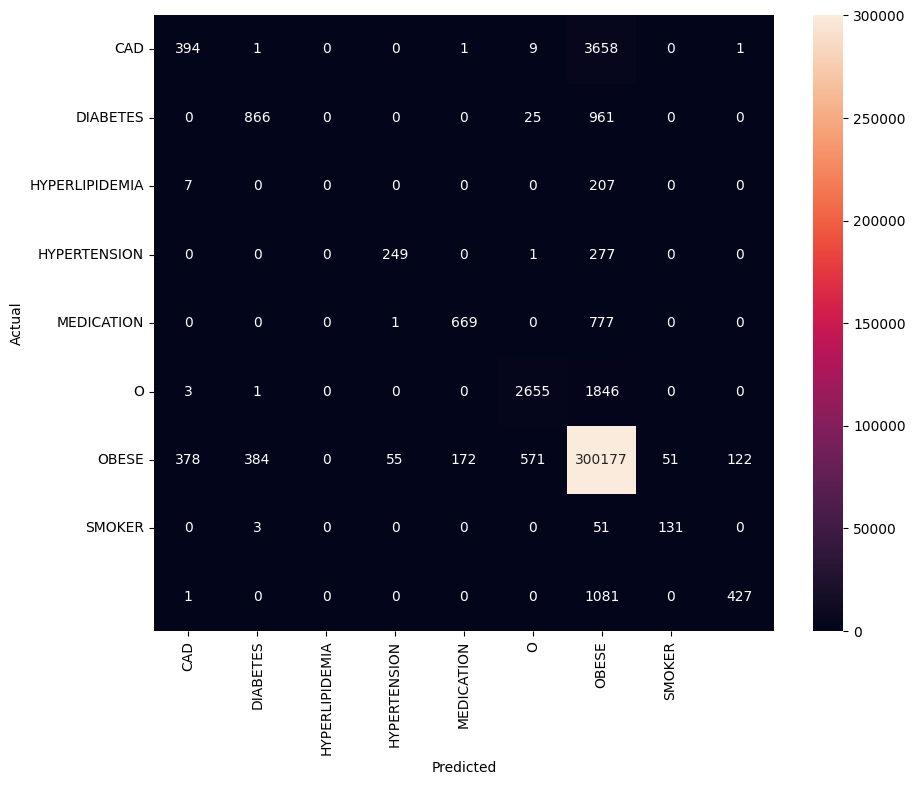

In [52]:
#Naive bayes
nb = MultinomialNB(alpha=.0005)
nb.partial_fit(x_train, y_train,classes=classes)

print (classification_report(y_pred=nb.predict(x_test), y_true=y_test, labels=new_classes))

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

y_pred = nb.predict(x_test)
conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=classes, yticklabels=classes)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [53]:
'''
#decision tree
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt.fit(x_train, y_train)

print (classification_report(y_pred=dt.predict(x_test), y_true=y_test, labels=new_classes))

y_pred = dt.predict(x_test)
'''

'\n#decision tree\nfrom sklearn.tree import DecisionTreeClassifier\ndt = DecisionTreeClassifier()\ndt.fit(x_train, y_train)\n\nprint (classification_report(y_pred=dt.predict(x_test), y_true=y_test, labels=new_classes))\n\ny_pred = dt.predict(x_test)\n'

## Prediction 

In [54]:
print(y_pred)

['O' 'O' 'O' ... 'O' 'O' 'O']


In [55]:
vadicationlist = testinglist.copy()
vadicationlist.insert(3, 'pred_label', '')

vadicationlist['pred_label'] = y_pred

vadicationlist.groupby('pred_label').count().sort_values(by='text',ascending=False)

,file,text,label
pred_label,,,
O,309035,309035,309035
MEDICATION,3261,3261,3261
DIABETES,1255,1255,1255
HYPERTENSION,842,842,842
CAD,783,783,783
SMOKER,550,550,550
HYPERLIPIDEMIA,305,305,305
OBESE,182,182,182


In [56]:
print(vadicationlist.groupby(['label']).count().sort_values(by='text',ascending=False).drop(['file','pred_label'],axis=1))
print(vadicationlist.groupby(['pred_label']).count().sort_values(by='text',ascending=False).drop(['file','label'],axis=1))

                  text
label                 
O               301910
MEDICATION        4505
CAD               4064
DIABETES          1852
SMOKER            1509
HYPERTENSION      1447
HYPERLIPIDEMIA     527
FAMILY_HIST        214
OBESE              185
                  text
pred_label            
O               309035
MEDICATION        3261
DIABETES          1255
HYPERTENSION       842
CAD                783
SMOKER             550
HYPERLIPIDEMIA     305
OBESE              182


In [57]:
#get the different result
wrongresult = vadicationlist[vadicationlist['label']!=vadicationlist['pred_label']].copy()
print(wrongresult)
sorted_wrong_result = wrongresult.groupby('text').count().sort_values(by='label', ascending=False) #sort the wrong result by the number of times it appears
print(sorted_wrong_result[:15])


    file                 text       label  pred_label
29     2  hydrochlorothiazide           O  MEDICATION
47     2                 pack           O      SMOKER
53     2                  cut      SMOKER           O
54     2                 back      SMOKER           O
55     2                  his      SMOKER           O
..   ...                  ...         ...         ...
286  514                years      SMOKER           O
288  514                   30      SMOKER           O
290  514                 year      SMOKER           O
291  514              history      SMOKER           O
669  514            Losartan,  MEDICATION           O

[10645 rows x 4 columns]
          file  label  pred_label
text                             
of         165    165         165
in         144    144         144
artery     129    129         129
and        119    119         119
to         110    110         110
coronary   103    103         103
the         96     96          96
with        87     8

In [58]:
print(wrongresult[wrongresult['text'] == 'hypertension,'])

    file           text label    pred_label
330   54  hypertension,     O  HYPERTENSION
624   54  hypertension,     O  HYPERTENSION
303   80  hypertension,     O  HYPERTENSION
184   95  hypertension,     O  HYPERTENSION
210   97  hypertension,     O  HYPERTENSION
308  102  hypertension,     O  HYPERTENSION
221  121  hypertension,     O  HYPERTENSION
212  130  hypertension,     O  HYPERTENSION
296  137  hypertension,     O  HYPERTENSION
294  213  hypertension,     O  HYPERTENSION
85   240  hypertension,   CAD  HYPERTENSION
289  306  hypertension,     O  HYPERTENSION
492  306  hypertension,     O  HYPERTENSION
156  309  hypertension,     O  HYPERTENSION
233  359  hypertension,     O  HYPERTENSION
90   368  hypertension,     O  HYPERTENSION
299  448  hypertension,     O  HYPERTENSION


In [59]:
vadicationlist['file']-1

0        0
1        0
2        0
3        0
4        0
      ... 
707    513
708    513
709    513
710    513
711    513
Name: file, Length: 316213, dtype: object

In [60]:
#group the vadicationlist by file
vadicationlist_grouped = vadicationlist.groupby('file')
vadicationlist_grouped_list = []
for name,group in vadicationlist_grouped:
    vadicationlist_grouped_list.append(group)

print(vadicationlist_grouped_list[0])

#delete the 'file' column
for i in range(len(vadicationlist_grouped_list)):
    vadicationlist_grouped_list[i] = vadicationlist_grouped_list[i].drop(['file'],axis=1)


    file        text label pred_label
0      1      Record     O          O
1      1       date:     O          O
2      1  2069-04-07     O          O
3      1         Mr.     O          O
4      1    Villegas     O          O
..   ...         ...   ...        ...
290    1    reviewed     O          O
291    1          by     O          O
292    1   Attending     O          O
293    1    Provider     O          O
294    1    ********     O          O

[295 rows x 4 columns]


In [61]:
print(vadicationlist_grouped_list)

[           text label pred_label
0        Record     O          O
1         date:     O          O
2    2069-04-07     O          O
3           Mr.     O          O
4      Villegas     O          O
..          ...   ...        ...
290    reviewed     O          O
291          by     O          O
292   Attending     O          O
293    Provider     O          O
294    ********     O          O

[295 rows x 3 columns],                    text label pred_label
0                Record     O          O
1                 date:     O          O
2            2075-01-07     O          O
3                 NAME:     O          O
4             Villegas,     O          O
..                  ...   ...        ...
196             Gilbert     O          O
197                  P.     O          O
198              Perez,     O          O
199                M.D.     O          O
200  GPP/church/olinger     O          O

[201 rows x 3 columns],            text label pred_label
0        Record     O       

In [62]:
vadicationlist_grouped_list[0].shape

(295, 3)

In [63]:
Pred_text_tag = []
for i in range(len(vadicationlist_grouped_list)):
    Pred_text_tag_eachfile = []
    for j in range(len(vadicationlist_grouped_list[i])):
        Pred_text_tag_eachfile.append(vadicationlist_grouped_list[i]['text'][j]+' '+vadicationlist_grouped_list[i]['label'][j]+' '+vadicationlist_grouped_list[i]['pred_label'][j])
    Pred_text_tag.append(Pred_text_tag_eachfile)

In [64]:
print(len(Pred_text_tag[0]))
print(len(Pred_text_tag[1]))

295
201


In [65]:
corpus_test['Pred_text_tag'] = Pred_text_tag

In [66]:
corpus_test['Pred_text_tag'][0]

['Record O O',
 'date: O O',
 '2069-04-07 O O',
 'Mr. O O',
 'Villegas O O',
 'is O O',
 'seen O O',
 'today. O O',
 'I O O',
 'have O O',
 'not O O',
 'seen O O',
 'him O O',
 'since O O',
 'November. O O',
 'About O O',
 'three O O',
 'weeks O O',
 'ago O O',
 'he O O',
 'stopped O O',
 'his O O',
 'Prednisone O O',
 'on O O',
 'his O O',
 'own O O',
 'because O O',
 'he O O',
 'was O O',
 'gaining O O',
 'weight. O O',
 'He O O',
 'does O O',
 'feel O O',
 'that O O',
 'his O O',
 'shoulders O O',
 'are O O',
 'definitely O O',
 'improved. O O',
 'It O O',
 'is O O',
 'unclear O O',
 'what O O',
 'he O O',
 'is O O',
 'actually O O',
 'taking, O O',
 'but O O',
 'I O O',
 'think O O',
 'based O O',
 'on O O',
 'the O O',
 'color O O',
 'of O O',
 'his O O',
 'pills O O',
 'and O O',
 'the O O',
 'timing O O',
 'of O O',
 'the O O',
 'medication O O',
 'that O O',
 'he O O',
 'continues O O',
 'taking O O',
 'his O O',
 'Atenolol MEDICATION MEDICATION',
 'for O O',
 'hypertension HYP

In [67]:
#save the corpus to a csv file
corpus_test.to_csv('E:/JHU/课程/datadesign/NLP/machine_learning/corpus_test.csv',index=False,encoding='utf-8')

# Doc-level Prediction

In [68]:
Pred_doc_tag = []
#delete repeated tags
for i in range(len(vadicationlist_grouped_list)):
    Pred_doc_tag_eachfile = []
    for j in range(len(vadicationlist_grouped_list[i])):
        Pred_doc_tag_eachfile.append(vadicationlist_grouped_list[i]['pred_label'][j])
    Pred_doc_tag_eachfile = list(set(Pred_doc_tag_eachfile))
    Pred_doc_tag_eachfile.remove('O')
    Pred_doc_tag.append(Pred_doc_tag_eachfile)
#vadicationlist_grouped_list[0]['pred_label']

In [69]:
print(Pred_doc_tag[2])

['CAD', 'HYPERLIPIDEMIA', 'SMOKER', 'DIABETES', 'HYPERTENSION', 'MEDICATION', 'OBESE']


In [70]:
corpus_test['Pred_tag_doc'] = Pred_doc_tag

In [71]:
#save the corpus to a csv file
corpus_test.to_csv('E:/JHU/课程/datadesign/NLP/machine_learning/corpus_test.csv',index=False,encoding='utf-8')

## Rule-based doc-level prediction for SMOKER

In [72]:
file2tag = {}
import os

with open('./TestingFAMILY_HIST.txt','r') as f:
    for line in f:
        lineInfo = line.strip().split(' ')
        if len(lineInfo) > 1:
            fileName = lineInfo[1]
            if fileName in file2tag: file2tag[fileName].append(lineInfo[2:])
            else: file2tag[fileName] = [lineInfo[2:]]

SMOKER_path = './Smoker/'

for fileName in os.listdir(testingpath): #Input EHRs
    with open(testingpath+'/'+fileName,'r') as f:
        with open(SMOKER_path+fileName,'w') as fw: #Can change this to any folder name you want (this is where it puts the outputs)
            f.readline()
            f.readline()
            fileString = ''
            tags = False
            tagsList = []
            doccount = 0
            fw.write("<?xml version='1.0' encoding='UTF-8'?>\n")
            fw.write("<root>\n")
            for line in f.readlines():
                fileString += line
                if tags: tagsList.append(line)
                else: fw.write(line)
                if '<TAGS>' in line: tags = True
            histKnown = False
            for tag in file2tag[fileName]:
                typeOfTag = tag[-1].strip().replace('\n','').replace('\t','')
                if typeOfTag == 'familyhistory':
                    histKnown = True
            if not histKnown:
                fw.write("\t<FAMILY_HIST id=\"DOC"+str(doccount)+"\" indicator=\"not present\"/>\n")
                doccount += 1
            else:
                fw.write("\t<FAMILY_HIST id=\"DOC"+str(doccount)+"\" indicator=\"present\"/>\n")
                doccount += 1
            fw.write('\t</TAGS>\n')
            fw.write('</root>')

In [73]:
SMOKER_prediction = []

for file in os.listdir(SMOKER_path):
    tree = ET.parse(SMOKER_path+file)
    root = tree.getroot()
    tags = root.findall('TAGS')
    for tag in tags:
        for child in tag:
            if child.tag == 'FAMILY_HIST':
                #in family history, the indicator is either present or not present, store it in the list
                SMOKER_prediction.append(child.attrib['indicator']) 
                

print(len(SMOKER_prediction))


514


In [74]:
#count the number of 'present'
print(SMOKER_prediction.count('present'))

4


In [75]:
for i in range(len(SMOKER_prediction)):
    if SMOKER_prediction[i] == 'present':
        #if the indicator is present, add the tag 'FAMILY_HIST' to the the doc-level tag list
        Pred_doc_tag[i].append('FAMILY_HIST')

In [76]:
#Count the number of 'FAMILY_HIST' in the doc-level tag list
count = 0
for i in range(len(Pred_doc_tag)):
    if 'FAMILY_HIST' in Pred_doc_tag[i]:
        count += 1
print(count)

4


In [77]:
corpus_test['Pred_tag_doc'] = Pred_doc_tag #update the doc-level tag list

In [78]:
#save the corpus to a csv file
corpus_test.to_csv('E:/JHU/课程/datadesign/NLP/machine_learning/corpus_test.csv',index=False,encoding='utf-8')

# Evaluation

In [79]:
Evaluation = pd.DataFrame(columns=['file','Real_tag_doc','Pred_tag_doc'])
Evaluation['file'] = corpus_test.index
Evaluation['Real_tag_doc'] = corpus_test['Real_tag_doc']
Evaluation['Pred_tag_doc'] = Pred_doc_tag

Evaluation

,file,Real_tag_doc,Pred_tag_doc
0,0,"[HYPERTENSION, MEDICATION]","[HYPERTENSION, MEDICATION]"
1,1,"[HYPERTENSION, SMOKER]","[HYPERTENSION, MEDICATION, SMOKER]"
2,2,"[CAD, HYPERLIPIDEMIA, SMOKER, DIABETES, HYPERT...","[CAD, HYPERLIPIDEMIA, SMOKER, DIABETES, HYPERT..."
3,3,"[CAD, HYPERLIPIDEMIA, DIABETES, HYPERTENSION, ...","[CAD, HYPERLIPIDEMIA, DIABETES, HYPERTENSION, ..."
4,4,"[HYPERTENSION, DIABETES, MEDICATION]","[HYPERTENSION, MEDICATION, DIABETES]"
...,...,...,...
509,509,"[HYPERLIPIDEMIA, SMOKER, DIABETES, HYPERTENSIO...","[HYPERLIPIDEMIA, SMOKER, DIABETES, HYPERTENSIO..."
510,510,[],[]
511,511,"[HYPERTENSION, DIABETES, SMOKER, MEDICATION]","[HYPERTENSION, DIABETES, MEDICATION]"
512,512,"[DIABETES, SMOKER, MEDICATION]","[CAD, SMOKER, DIABETES, MEDICATION]"


In [80]:
Evaluation['Real_tag_doc'][0]

['HYPERTENSION', 'MEDICATION']

In [81]:
def evaluate_each(list, taget_tag):
    TP = 0
    FP = 0
    FN = 0
    TN = 0
    for i in range(len(list)):
        if taget_tag in list['Real_tag_doc'][i]:
            if taget_tag in list['Pred_tag_doc'][i]:
                TP += 1
            else:
                FN += 1
        else:
            if taget_tag in list['Pred_tag_doc'][i]:
                FP += 1
            else:
                TN += 1
            
    #print('TP:',TP)
    #print('FP:',FP)
    #print('FN:',FN)
    return TP,FP,FN,TN

def evaluate_matrix(list, taget_tag_list = ['SMOKER', 'FAMILY_HIST']):
    
    score_matrix = pd.DataFrame(columns=['target_tag','TP','FP','FN','TN','precision','recall','F1','Support'])

    for taget_tag in taget_tag_list:
        score_matrix_each = pd.DataFrame(columns=['target_tag','TP','FP','FN','TN','precision','recall','F1','Support'])
        TP,FP,FN,TN = evaluate_each(list, taget_tag)
        if TP+FP == 0:
            if TP == 0:
                precision = 0
            else:
                precision = 1
        else:
            precision = TP/(TP+FP)
        if TP+FN == 0:
            if TP == 0:
                recall = 0
            else:
                recall = 1
        else:
            recall = TP/(TP+FN)
        if precision+recall == 0:
            if precision*recall == 0:
                F1 = 0
            else:
                F1 = 1
        else:
            F1 = 2*precision*recall/(precision+recall)
        
        score_matrix_each['target_tag'] = [taget_tag]
        score_matrix_each['TP'] = [TP]
        score_matrix_each['FP'] = [FP]
        score_matrix_each['FN'] = [FN]
        score_matrix_each['TN'] = [TN]
        score_matrix_each['precision'] = [precision]
        score_matrix_each['recall'] = [recall]
        score_matrix_each['F1'] = [F1]
        score_matrix_each['Support'] = [TP+FN]

        
        score_matrix = pd.concat([score_matrix,score_matrix_each],axis=0)
        
    return score_matrix

def total_score(score_matrix):  
    support_sum = score_matrix['Support'].sum()
    support_proportion = score_matrix['Support']/support_sum

    TP_sum = score_matrix['TP'].sum()
    FP_sum = score_matrix['FP'].sum()
    FN_sum = score_matrix['FN'].sum()
    TN_sum = score_matrix['TN'].sum()
    
    weighted_precision = (score_matrix['precision']*support_proportion).sum()
    weighted_recall = (score_matrix['recall']*support_proportion).sum()
    weighted_F1 = (score_matrix['F1']*support_proportion).sum()

    
    score_matrix = score_matrix.append({'target_tag':'Total_macro','TP':TP_sum,'FP':FP_sum,'FN':FN_sum, 'TN':TN_sum,
                                        'precision':score_matrix['precision'].mean(),'recall':score_matrix['recall'].mean(),'F1':score_matrix['F1'].mean(), 'Support':support_sum},ignore_index=True)
    score_matrix = score_matrix.append({'target_tag':'Total_micro','TP':TP_sum,'FP':FP_sum,'FN':FN_sum, 'TN':TN_sum,
                                        'precision':score_matrix['TP'].sum()/(score_matrix['TP'].sum()+score_matrix['FP'].sum()),'recall':score_matrix['TP'].sum()/(score_matrix['TP'].sum()+score_matrix['FN'].sum()),'F1':2*score_matrix['TP'].sum()/(2*score_matrix['TP'].sum()+score_matrix['FP'].sum()+score_matrix['FN'].sum()), 'Support':support_sum},ignore_index=True)
    score_matrix = score_matrix.append({'target_tag':'Total_weighted','TP':TP_sum,'FP':FP_sum,'FN':FN_sum, 'TN':TN_sum,
                                        'precision':weighted_precision,'recall':weighted_recall,'F1':weighted_F1, 'Support':support_sum},ignore_index=True)
    
    #print(score_matrix)
    return score_matrix



In [82]:
Evaluate_Matrix = evaluate_matrix(Evaluation,taget_tag_list =['MEDICATION','CAD','DIABETES','SMOKER','HYPERTENSION','HYPERLIPIDEMIA','OBESE','FAMILY_HIST'])

#no smoker
#Evaluate_Matrix = evaluate_matrix(Evaluation,taget_tag_list =['MEDICATION','CAD','DIABETES','HYPERTENSION','HYPERLIPIDEMIA','OBESE','FAMILY_HIST'])
Evaluate_Matrix

,target_tag,TP,FP,FN,TN,precision,recall,F1,Support
0,MEDICATION,448,5,3,58,0.988962,0.993348,0.991150,451
0,CAD,182,47,44,241,0.794760,0.805310,0.800000,226
0,DIABETES,346,30,18,120,0.920213,0.950549,0.935135,364
0,SMOKER,259,9,65,181,0.966418,0.799383,0.875000,324
0,HYPERTENSION,369,12,24,109,0.968504,0.938931,0.953488,393
0,HYPERLIPIDEMIA,203,6,46,259,0.971292,0.815261,0.886463,249
0,OBESE,81,14,6,413,0.852632,0.931034,0.890110,87
0,FAMILY_HIST,3,1,16,494,0.750000,0.157895,0.260870,19


In [83]:
total_score(Evaluate_Matrix)

C:\Users\52594\AppData\Local\Temp\ipykernel_54608\1176011773.py:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  score_matrix = score_matrix.append({'target_tag':'Total_macro','TP':TP_sum,'FP':FP_sum,'FN':FN_sum, 'TN':TN_sum,
C:\Users\52594\AppData\Local\Temp\ipykernel_54608\1176011773.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  score_matrix = score_matrix.append({'target_tag':'Total_micro','TP':TP_sum,'FP':FP_sum,'FN':FN_sum, 'TN':TN_sum,
C:\Users\52594\AppData\Local\Temp\ipykernel_54608\1176011773.py:85: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  score_matrix = score_matrix.append({'target_tag':'Total_weighted','TP':TP_sum,'FP':FP_sum,'FN':FN_sum, 'TN':TN_sum,


,target_tag,TP,FP,FN,TN,precision,recall,F1,Support
0,MEDICATION,448,5,3,58,0.988962,0.993348,0.991150,451
1,CAD,182,47,44,241,0.794760,0.805310,0.800000,226
2,DIABETES,346,30,18,120,0.920213,0.950549,0.935135,364
3,SMOKER,259,9,65,181,0.966418,0.799383,0.875000,324
4,HYPERTENSION,369,12,24,109,0.968504,0.938931,0.953488,393
5,HYPERLIPIDEMIA,203,6,46,259,0.971292,0.815261,0.886463,249
6,OBESE,81,14,6,413,0.852632,0.931034,0.890110,87
7,FAMILY_HIST,3,1,16,494,0.750000,0.157895,0.260870,19
8,Total_macro,1891,124,222,1875,0.901598,0.798964,0.824027,2113
9,Total_micro,1891,124,222,1875,0.938462,0.894936,0.916182,2113


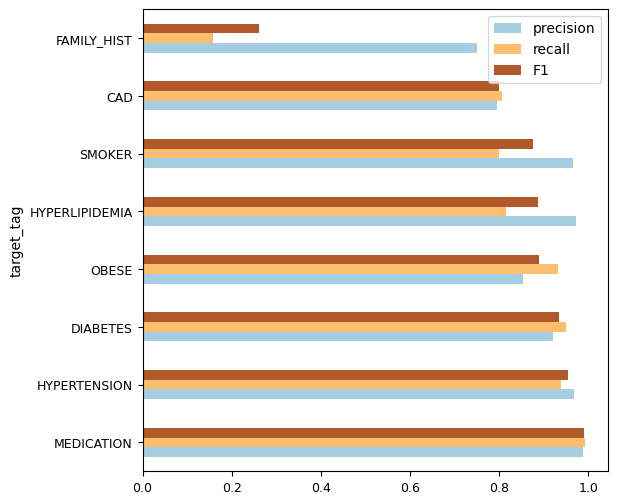

In [84]:
#plot the precision recall F1 
import matplotlib.pyplot as plt
import numpy as np

def plot_score(score_matrix):
    #sco
    score_matrix = score_matrix.sort_values(by=['F1'],ascending=False)
    score_matrix = score_matrix.reset_index(drop=True)
    score_matrix = score_matrix.drop(['TP','FP','FN','TN','Support'],axis=1)
    score_matrix = score_matrix.set_index('target_tag')
    score_matrix.plot(kind='barh',figsize=(6,6),fontsize=9, colormap='Paired')
    plt.show()

plot_score(Evaluate_Matrix)





In [85]:
#accuracy
accuracy = (Evaluate_Matrix['TP'].sum()+Evaluate_Matrix['TN'].sum())/(Evaluate_Matrix['TP'].sum()+Evaluate_Matrix['TN'].sum()+Evaluate_Matrix['FP'].sum()+Evaluate_Matrix['FN'].sum())
print('accuracy:',accuracy)

accuracy: 0.9158560311284046
